In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lyft-udacity-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F27201%2F34686%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T132213Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D439b66b85f6fc951c880aef61529adc4e9c08558a324ef68235b523c0fd66d0e05acf9273581b1a49f3e05a3df7e4440e78ba1ab675bd061f8b586f426689d540b2a47d7f90773f28f6482367551b09e7dedd2df08da887edaab88e16f2216d1cd886a7c1c3b3c0c15deab174d781a0cb8458cd04e3c9b8555ab72ae71686e3c014f7096cefaaf68cca803cf6c816d6f3a9aee20eef170c6e7d309d895357e6f856fe938bdc276c794722aeddca46ad25f3136366a5cecec1ad963d2f62d17bc4f526a8e8a23770f78c7b30fa0da2f200201ba6d3f055bc45fc848b640cd70cae4bc6b828d17ac77a9d5a20481d0a2e91b167e748158b16376434d641fd9f3c2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5485605432 bytes downloaded
Downloaded and uncompressed: lyft-udacity-challenge
Data source import complete.


In [ ]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Dataset

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


class Custom_Dataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform = None):
        self.transforms = transform
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,index):
        img = np.array(Image.open(self.image_paths[index]))
        mask = np.array(Image.open(self.mask_paths[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            mask = torch.max(mask,dim=2)[0]
        return img,mask

transform = A.Compose([
    #A.Resize(256,256),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

def data_generator(image_paths, mask_paths, batch_size):
    dataset = Custom_Dataset(image_paths, mask_paths, transform = tf)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return dataloader

In [ ]:
image_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

image_paths = []
for i in range(len(image_path)):
    for name in os.listdir(image_path[i]):
        image_paths.append(image_path[i] + name)

mask_paths = []
for i in range(len(mask_path)):
    for name in os.listdir(mask_path[i]):
        mask_paths.append(mask_path[i] + name)

from sklearn.model_selection import train_test_split
train_image_paths, val_test_image_paths, train_mask_paths, val_test_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(val_test_image_paths, val_test_mask_paths, train_size=0.8, random_state=0)

In [ ]:
print(len(train_image_paths), len(val_image_paths), len(test_image_paths))

4000 800 200


In [ ]:
batch_size = 32

train_dataset = data_generator(train_image_paths, train_mask_paths, batch_size)
val_dataset = data_generator(val_image_paths, val_mask_paths, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, batch_size)

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

125 25 7


## Transforms

In [ ]:
import random
import imageio
import warnings
warnings.filterwarnings('ignore')

nums = len(image_paths)
for _ in range(3):
    N = random.randint(0, nums - 1)
    img = imageio.imread(image_paths[N])
    mask = imageio.imread(mask_paths[N])
    mask = np.max(mask, axis=-1) # max каждого пикселя по цветовым каналам (H x W x channels)
    fig, arr = plt.subplots(1, 2, figsize=(20, 8))
    arr[0].imshow(img)
    arr[1].imshow(mask)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Architecture

In [ ]:
pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-64x2xztw
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-64x2xztw
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=13,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [ ]:
print(model)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

# Training + Metrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
learning_rate = 1e-3
num_epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()
scheduler = OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train_dataset), epochs=num_epochs)

In [ ]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [ ]:
log_file = open('accuracy_log.txt', 'w')

In [ ]:
def train_model(model, train_loader, valid_loader, loss_function, optimizer, num_epochs=10, device='cpu'):
  best_valid_accuracy = 0.0
  best_weights = model.state_dict()

  for epoch in range(10):
    print(f'Number of epoch - {epoch+1}')
    model.train()
    train_loss = 0.0
    train_corrects = 0
    num_elems1 = 0
    loop = tqdm(enumerate(train_dataset), total=len(train_dataset))

    for batch_idx, (data, targets) in loop:
        data, targets = data.to(device), targets.to(device)
        targets = targets.type(torch.long)

        softmax = nn.Softmax(dim=1)
        preds = torch.argmax(softmax(model(data)),axis=1)
        num_elems1 += torch.numel(preds)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(predictions, 1)
        train_corrects += (predicted == targets).sum()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    scheduler.step()
    model.eval()
    valid_loss = 0.0
    valid_corrects = 0
    num_elems = 0

    with torch.no_grad():
        for x, y in val_dataset:
            x, y = x.to(device), y.to(device)
            y = y.type(torch.long)

            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            valid_corrects += (preds == y).sum()
            num_elems += torch.numel(preds)

            outputs = model(x)
            loss = loss_fn(outputs, y)
            valid_loss += loss.item()

    train_loss = train_loss/len(train_dataset)
    valid_loss = valid_loss/len(val_dataset)

    train_accuracy = train_corrects/num_elems1 * 100
    valid_accuracy = valid_corrects/num_elems * 100

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} -> '
          f'Train Loss: {train_loss:.4f}, Train Accuracy:  {train_accuracy:.2f}% | '
          f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%' + '\n')

    log_file.write(f'Epoch {epoch + 1}/{num_epochs} -> '
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | '
        f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%'+ '\n')

    if valid_accuracy > best_valid_accuracy:
      best_valid_accuracy = valid_accuracy
      best_weights = model.state_dict()
      torch.save(model.state_dict(), f'best_weights_epoch{epoch + 1}.pth')

  print('Training complete!')
  return best_weights

In [ ]:
best_weights = train_model(model, train_dataset, val_dataset, loss_fn, optimizer, num_epochs=num_epochs, device=device)
log_file.close()

Number of epoch - 1


100%|██████████| 125/125 [02:17<00:00,  1.10s/it, loss=0.377]


Epoch 1/10 -> Train Loss: 0.8994, Train Accuracy:  78.73% | Validation Loss: 0.3744, Validation Accuracy: 90.96%

Number of epoch - 2


100%|██████████| 125/125 [02:16<00:00,  1.10s/it, loss=0.266]


Epoch 2/10 -> Train Loss: 0.2934, Train Accuracy:  92.15% | Validation Loss: 0.2535, Validation Accuracy: 92.66%

Number of epoch - 3


100%|██████████| 125/125 [02:17<00:00,  1.10s/it, loss=0.197]


Epoch 3/10 -> Train Loss: 0.2273, Train Accuracy:  93.30% | Validation Loss: 0.2067, Validation Accuracy: 93.77%

Number of epoch - 4


100%|██████████| 125/125 [02:17<00:00,  1.10s/it, loss=0.176]


Epoch 4/10 -> Train Loss: 0.1895, Train Accuracy:  94.14% | Validation Loss: 0.1745, Validation Accuracy: 94.50%

Number of epoch - 5


100%|██████████| 125/125 [02:17<00:00,  1.10s/it, loss=0.15]


Epoch 5/10 -> Train Loss: 0.1651, Train Accuracy:  94.81% | Validation Loss: 0.1578, Validation Accuracy: 95.03%

Number of epoch - 6


100%|██████████| 125/125 [02:18<00:00,  1.10s/it, loss=0.138]


Epoch 6/10 -> Train Loss: 0.1474, Train Accuracy:  95.31% | Validation Loss: 0.1409, Validation Accuracy: 95.47%

Number of epoch - 7


100%|██████████| 125/125 [02:17<00:00,  1.10s/it, loss=0.138]


Epoch 7/10 -> Train Loss: 0.1349, Train Accuracy:  95.62% | Validation Loss: 0.1308, Validation Accuracy: 95.70%

Number of epoch - 8


100%|██████████| 125/125 [02:16<00:00,  1.09s/it, loss=0.117]


Epoch 8/10 -> Train Loss: 0.1236, Train Accuracy:  95.91% | Validation Loss: 0.1206, Validation Accuracy: 95.96%

Number of epoch - 9


100%|██████████| 125/125 [02:17<00:00,  1.10s/it, loss=0.1]


Epoch 9/10 -> Train Loss: 0.1156, Train Accuracy:  96.10% | Validation Loss: 0.1133, Validation Accuracy: 96.14%

Number of epoch - 10


100%|██████████| 125/125 [02:16<00:00,  1.10s/it, loss=0.103]


Epoch 10/10 -> Train Loss: 0.1088, Train Accuracy:  96.26% | Validation Loss: 0.1090, Validation Accuracy: 96.23%

Training complete!


# Графики и примеры

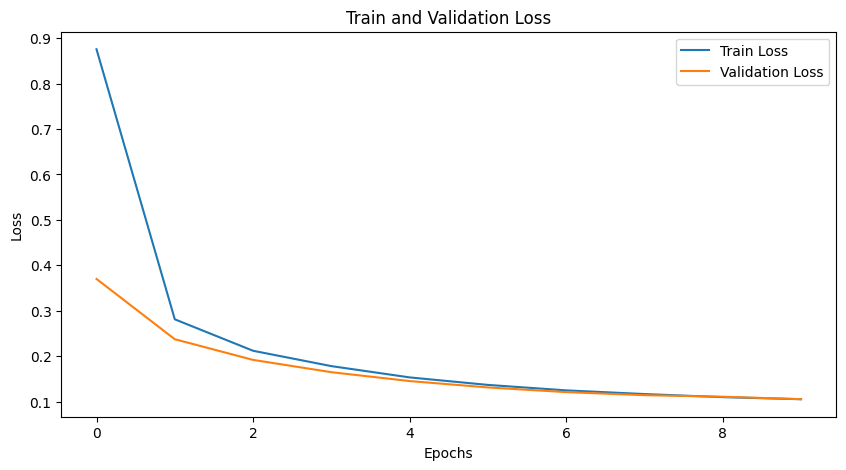

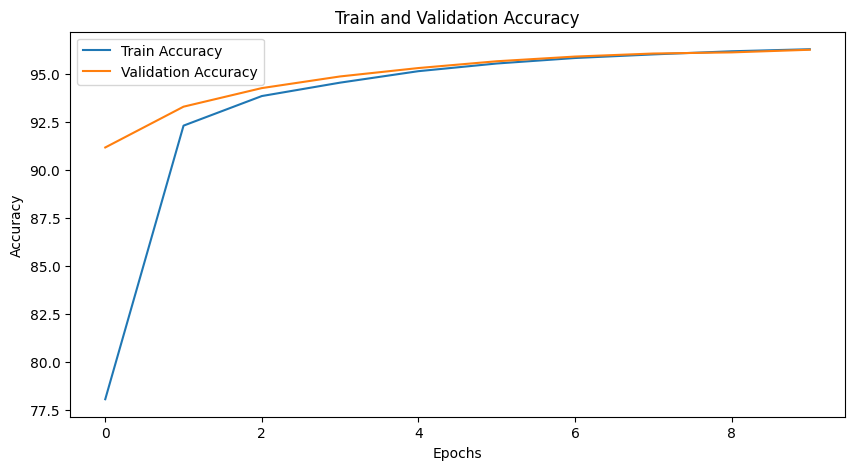

In [ ]:
import matplotlib.pyplot as plt

# Loss function
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Accuracy
# преобразования тензоров c CUDA (GPU) в объекты NumPy не допускаются напрямую
train_accuracies_cpu = [acc.cpu().numpy() for acc in train_accuracies]
valid_accuracies_cpu = [acc.cpu().numpy() for acc in valid_accuracies]

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_cpu, label='Train Accuracy')
plt.plot(valid_accuracies_cpu, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()

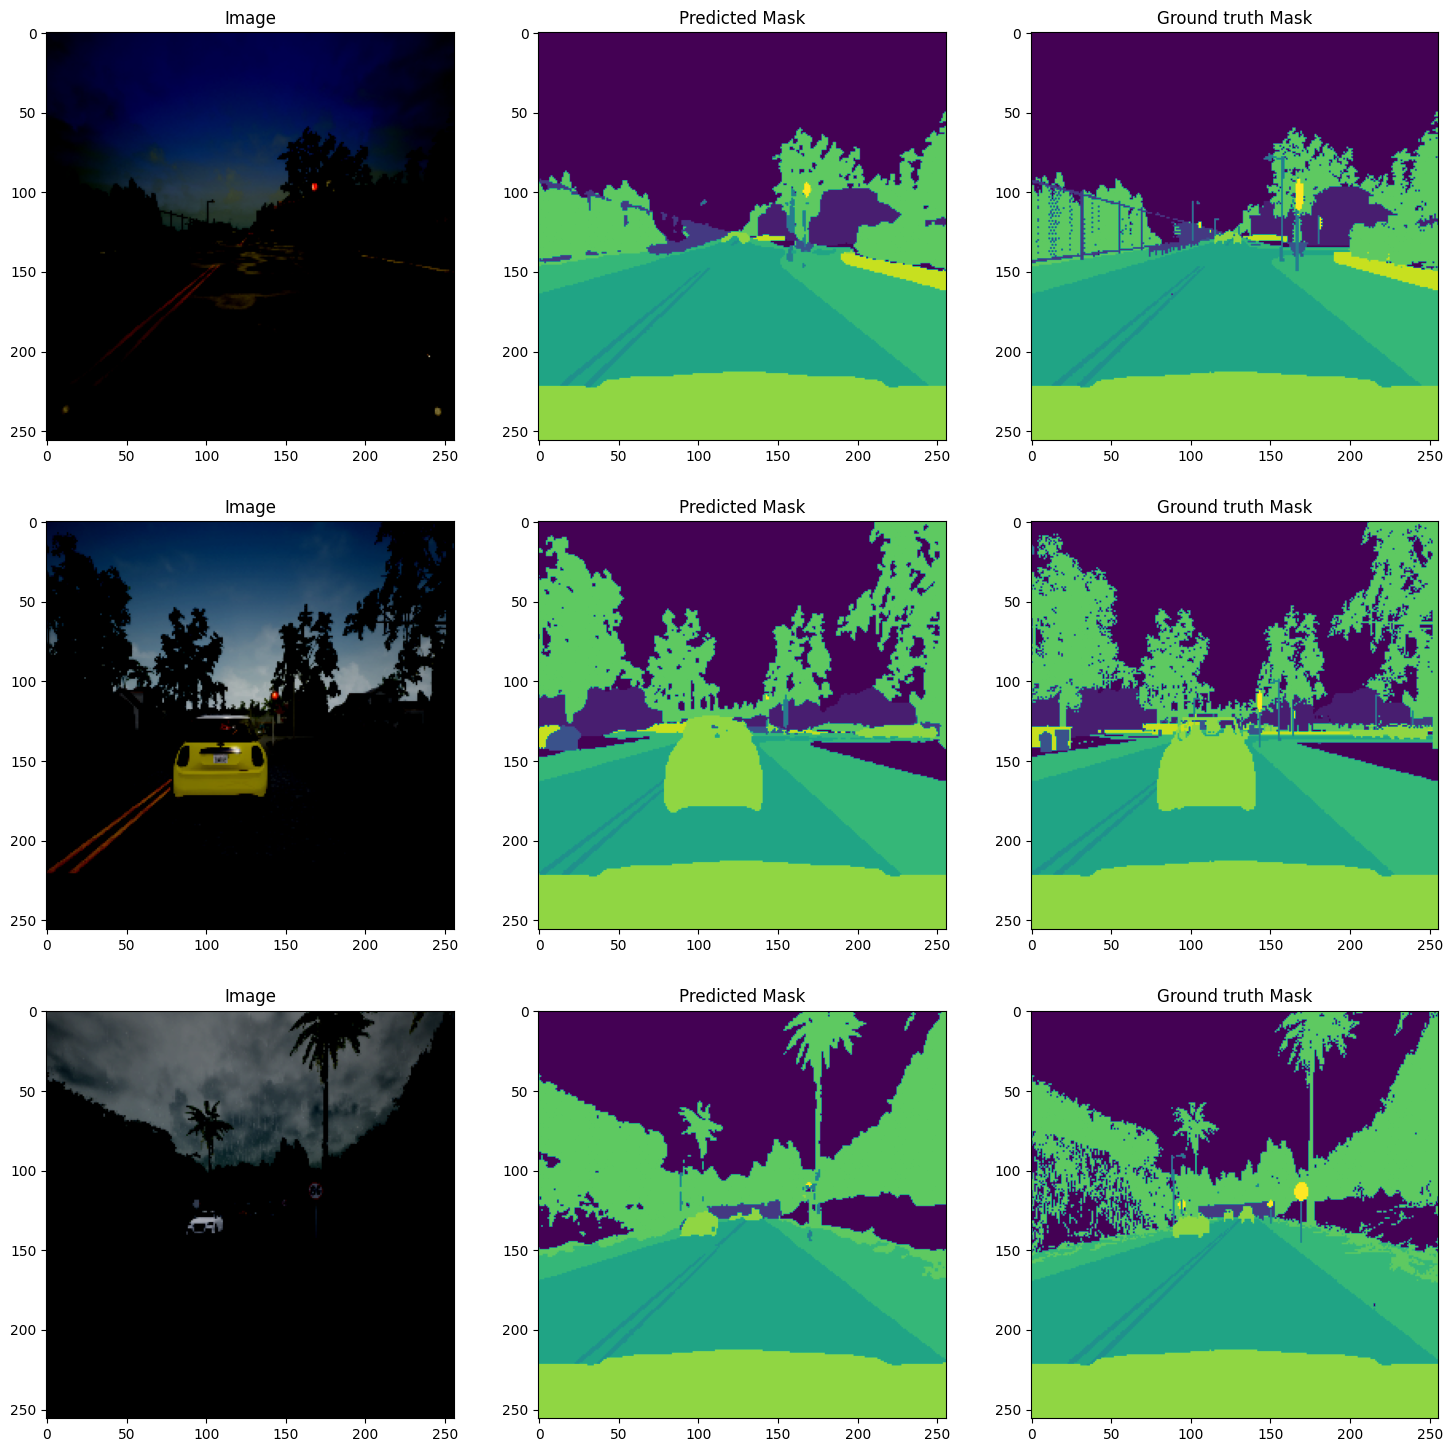

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for x, y in test_dataset:
    x = x.to(device)
    fig, ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')

    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])

    ax[0,0].set_title('Изображение')
    ax[0,1].set_title('Предсказание')
    ax[0,2].set_title('Ground truth')

    ax[1,0].set_title('Изображение')
    ax[1,1].set_title('Предсказание')
    ax[1,2].set_title('Ground truth')

    ax[2,0].set_title('Изображение')
    ax[2,1].set_title('Предсказание')
    ax[2,2].set_title('Ground truth')

    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)

    break

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/accuracy_log.txt" "/content/drive/My Drive/final/"